<a href="https://colab.research.google.com/github/suhacker1/MathResearchQHSS/blob/master/Agora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Need to do a contingency table with cat categories

In [1]:
!pip install -U -q PyDrive

# HERE YOUR FILE ID
csv_id = '1HEKoLxr1rJ_iL8Wb_v7XX5C85AngX8UN'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# DOWNLOAD FILE
print ("Downloading file")
myzip = drive.CreateFile({'id': csv_id})
myzip.GetContentFile('Agora.csv')

# Data Loading / Preprocessing

In [2]:
# General
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Regex
import re

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Warnings OFF
import warnings
warnings.filterwarnings('ignore')

# Load
df = pd.read_csv('Agora.csv', encoding="latin1")
df.columns = [x.replace(" ", "") for x in df.columns] # Strip Column variable names from spaces
print("Data Load Complete")

Data Load Complete


In [3]:
# Change Dtype
df.Item = df.Item.astype(str)

"""
Regex Cleaning of Destination and Origin Column. Still very Messy and Deceptive.
#1 Remove non-words and strip the strings of outlying blank spaces, and
lowercase all characters, while capitalizing the first letter
#2 Remove instances of "only". Redundant information.
#3 Transform all the iterations of the term "worldwide"
#4&5 Transform all the iterations of united states and united kingdom

Regular Expression Explanation:
- [a-zA-Z]{2} # More than two letters
- |[/] # Or, the character " / "
"""

for x in ["Origin","Destination"]:
    df[x] = df[x].str.capitalize().str.replace('[^\w\s]','') # 1
    df[x] = df[x].str.replace(r"\bonly\b", '').str.strip() # 2 
    df.loc[df[x].str.contains(r"(?i)world|\b(?i)word\b|(?i)global",na=False),x] = "Worldwide" # 3
    df.loc[df[x].str.contains(r"(?i)kingdom",na=False),x] = "Uk" # 4
    df.loc[df[x].str.contains(r"(?i)(\bunited states\b)|\b(?i)us\b",na=False),x] = "Usa" # 5
print("Cleaning of 'Origin' and 'Destination' Complete")
##

# Remove BTC suffix
df["BTC"] = df['Price'].str.replace('BTC', '')

# Remove nan
df = df[pd.notnull(df['BTC'])]

##

"""
Dirty Data:
Here, it appears like non-price information made its way into the `BTC` variable columns. These are to be removed.
Diagnose for random junk in Bitcoin Price Column
Reference- https://stackoverflow.com/questions/10439666/regex-pattern-any-two-letters-followed-by-six-numbers
"""
regex1= r'[a-zA-Z]{2}|[/]'
# Delete Junk
df = df[~df['BTC'].str.contains(regex1)]
# To float.
df.BTC = pd.to_numeric(df.BTC)

##

# Convert to Dollar Value with 2014/2015 Average (399)
# Scaling, and Rounding
df["Value"] = (df.BTC * 399).round(3)
df["LogValue"]= np.log(df.Value).round(3)
print("Bitcoin/Value Variable Cleaned")

##
"""
Extract Sub-Categories and Create New Columns:
The Rating variable has includes is total score: e.i 4.5/5. Also plagued with "Number of Deals",
an unfortunate mash-up of two variables.
"""

# Regex Clean "Score" and extract Deals Count which found itself hiding within it
df["Score"]= df.Rating.str.split('/').str[0]
df["Deals"] = "NaN"
df["Deals"] = df.Score[df.Score.str.contains(r"(deal)", na=False)]
df.Score[df.Score.str.contains(r"(deal)", na=False)] = "NaN"
df.Score = df.Score.str.replace(r'(~)','')
df.Score = df.Score.astype(float)
df.Deals = df.Deals.str.extract('(\d+)')
print("Rating and Deal Variable Cleaned and Expanded")

"""
Parse Out Item Categories:
Currently in the form:  Drugs/Cannabis/Weed
Here, I split the categories up into seperate variables.
"""
df = pd.concat([df,df.Category.str.split('/', expand=True)], axis=1)
df = df.rename(columns={0: 'cat1', 1: 'cat2',2: 'cat3', 3: 'cat4'})
print("Item Category Variable Cleaned and Expanded")


Cleaning of 'Origin' and 'Destination' Complete
Bitcoin/Value Variable Cleaned
Rating and Deal Variable Cleaned and Expanded
Item Category Variable Cleaned and Expanded


In [4]:
list(df)

['Vendor',
 'Category',
 'Item',
 'ItemDescription',
 'Price',
 'Origin',
 'Destination',
 'Rating',
 'Remarks',
 'BTC',
 'Value',
 'LogValue',
 'Score',
 'Deals',
 'cat1',
 'cat2',
 'cat3',
 'cat4']

In [5]:
df['cat1'].unique(), df['cat2'].unique(), df['cat3'].unique(), df['cat4'].unique()

(array(['Services', 'Drugs', 'Forgeries', 'Tobacco', 'Counterfeits',
        'Data', 'Information', 'Electronics', 'Drug paraphernalia',
        'Other', 'Jewelry', 'Weapons', 'Info', 'Chemicals'], dtype=object),
 array(['Hacking', 'Other', 'RCs', 'Physical documents', 'Smoked', 'Money',
        'Software', 'Accounts', 'Clothing', 'eBooks', None, 'Pipes',
        'Weight loss', 'Pirated', 'Steroids', 'Prescription', 'Guides',
        'Scans', 'Accessories', 'Watches', 'Cannabis', 'Benzos',
        'Dissociatives', 'Ecstasy', 'Stimulants', 'Psychedelics',
        'Lethal firearms', 'Opioids', 'Stashes', 'Advertising', 'Melee',
        'Containers', 'Non-lethal firearms', 'Paraphernalia', 'Ammunition',
        'Grinders', 'Paper', 'Travel', 'Electronics',
        'Injecting equipment', 'Barbiturates', 'Fireworks', 'Scales'],
       dtype=object),
 array([None, 'Photos', 'Weed', 'Shake', 'Synthetics', 'Concentrates',
        'Seeds', 'Hash', 'MXE', 'Ketamine', 'Edibles', 'Pills', 'Other',

In [6]:
df['Origin'].unique()

array(['Torland', nan, 'Worldwide', 'Internet', 'Australia', 'Usa', 'Eu',
       'France', 'Uk', 'Canada', 'Netherlands', 'Swaziland', 'China',
       'China new zealand  russia  finland  germany or the middle east',
       'Eu ger and aus', 'Canada usa  uk  eu', 'Usa canada  w europe',
       'Eu nz  russia', 'Germany', 'Poland', 'Usa canda  w europe',
       'Ukraine', 'Switzerland', 'Theunitedsnakes', 'Italy', 'Mypm',
       'Japan', 'Hongkong', 'Uk usa  canada', 'Uk usa  europe', 'Sweden',
       'Denmark', 'Thailand', 'India', 'Me', 'Latvia', 'Europe',
       'Ukusa eu', 'Denmark norway and swizz', 'Europe uk and others',
       'Chinaoreu', 'Usa canada', 'Uk eu', 'Uk usa philippines',
       'Pakistan', 'Undeclared', 'Uk usa', 'Germany europe  schweiz',
       'Austria', 'Czechrepublic', 'Belgium', 'Singapore',
       'Uk europe  usa', 'Argentina', 'Panama', 'Canada usa',
       'Eu ru  sam', 'Netherlands exlude holland', 'Spain', 'Southafrica',
       'Germany norway  finland', 

# Data Visualization

## Helper Functions

In [7]:
# Count and Box for Category Level
def catplot(target, level):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,8), sharey=True)
    bar_count1 = df.groupby([target])[['LogValue']].count().sort_values(by='LogValue',ascending=False)
    ax1 = sns.barplot(x="LogValue", y=bar_count1.index, data=bar_count1, ax=ax1)
    ax1.set_xlabel('Count')
    ax1.set_title('Item Count by {}'.format(level))
    ax1.set_ylabel('{}'.format(level))

    # Box Plot
    ax2 = sns.boxplot(y=target, x="Value",order=bar_count1.index, data=df)
    ax2.set_xlabel('Log Dollar Value')
    ax2.set_title('Log Dollar Value for {}'.format(level))
    ax2.set_ylabel('')

    # Plot
    f.suptitle("Count and Box Plot for {}".format(level),fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    
# Simple Count Plot Helper Function
def countplot(level, label):
    plt.subplots(figsize=(8,7))
    bar_count= df.groupby([level])[['LogValue']].count().reset_index().sort_values(by='LogValue',ascending=False)
    ax = sns.barplot(x="LogValue", y=level, data=bar_count,palette="viridis")
    ax.set_xlabel('Count')
    ax.set_title('Item Count by {}'.format(label))
    ax.set_ylabel('General Categories')
    plt.show()
    
# Count and Box for Category Level
def catplot(target, level, size = (13,6)):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=size, sharey=True)
    bar_count1 = df.groupby([target])[['Value']].count().sort_values(by='Value',ascending=False)
    ax1 = sns.barplot(x="Value", y=bar_count1.index, data=bar_count1, ax=ax1,palette="inferno")
    ax1.set_xlabel('Count')
    ax1.set_title('Item Count by {}'.format(level))
    ax1.set_ylabel('{}'.format(level))

    # Box Plot
    ax2 = sns.boxplot(y=target, x="Value",order=bar_count1.index, data=df,palette="inferno")
    ax2.set_xlabel('Log Axis: Dollar Value')
    ax2.set_title('Dollar Value for {}'.format(level))
    ax2.set_ylabel('')
    ax2.set_xscale('log')

    # Plot
    f.suptitle("Count and Box Plot for {}".format(level),fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])
    
# Simple Count Plot Helper Function
def countplot(level, label, size= (10,7)):
    plt.subplots(figsize=size)
    bar_count= df.groupby([level])[['Value']].count().reset_index().sort_values(by='Value',ascending=False)
    ax = sns.barplot(x="Value", y=level, data=bar_count,palette="inferno")
    ax.set_xlabel('Count')
    ax.set_title('Item Count by {}'.format(label))
    ax.set_ylabel('General Categories')
    plt.show()
print("Plot Helper Functions Ready")

Plot Helper Functions Ready


In [0]:
# Plot Funciton
def catinabox_plot(target, parentcat, kitten, level, size = (13,6)):
    f, (ax1, ax2) = plt.subplots(1,2,figsize=size, sharey=True)
    # Count Bar
    bar_count1= df[df[parentcat]==target].groupby([kitten])[['Value']].count().sort_values(by='Value',ascending=False)
    ax1 = sns.barplot(x="Value", y=bar_count1.index, data=bar_count1, ax=ax1,palette="inferno")
    ax1.set_xlabel('Count')
    ax1.set_title('Item Count by {}'.format(target))
    ax1.set_ylabel('{}'.format(target))
    
    # Box
    ax2 = sns.boxplot(y=kitten, x="Value", order=bar_count1.index, data=df[df[parentcat]==target],palette="inferno")
    ax2.set_xlabel('Log Axis: Dollar Value')
    ax2.set_title('Dollar Value for General Categories')
    ax2.set_xscale('log')
    ax2.set_ylabel('')
    
    # Plot
    f.suptitle("{} Categories for {}".format(level,target),fontsize=20)
    f.tight_layout(rect=[0, 0.03, 1, 0.95])

## Actual Visualization

In [9]:
print("Glance into the Group and Subgroup Structure:")
df.loc[:,["Category","cat1","cat2","cat3","cat4"]].sample(7)

Glance into the Group and Subgroup Structure:


,Category,cat1,cat2,cat3,cat4
58331,Drugs/Psychedelics/DMT,Drugs,Psychedelics,DMT,None
66203,Drugs/Stimulants/Meth,Drugs,Stimulants,Meth,None
69335,Drugs/Stimulants/Meth,Drugs,Stimulants,Meth,None
92841,Counterfeits/Watches,Counterfeits,Watches,None,None
74106,Drugs/Cannabis/Synthetics,Drugs,Cannabis,Synthetics,None
54907,Drugs/Cannabis/Seeds,Drugs,Cannabis,Seeds,None
75082,Drugs/Ecstasy/MDMA,Drugs,Ecstasy,MDMA,None


Groups without Sub-Categories: ['Electronics' 'Other' 'Jewelry' 'Forgeries' 'Chemicals']


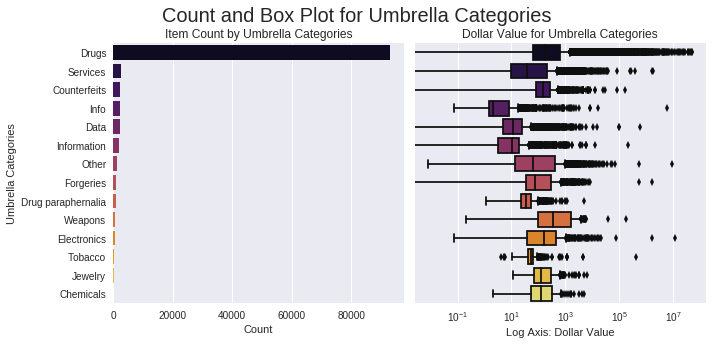

In [10]:
catplot(target="cat1", level="Umbrella Categories", size = (10,5))
regex1= r'^((?!/).)*$'
print("Groups without Sub-Categories:",df['Category'][df['Category'].str.contains(regex1, na=True)].unique())

Unique Subcategory for Tier Two with SubClass:
 ['Services' 'Drugs' 'Forgeries' 'Tobacco' 'Counterfeits' 'Data'
 'Information' 'Drug paraphernalia' 'Weapons' 'Info']

Tier Two Subcategories
['Hacking' 'Other' 'RCs' 'Physical documents' 'Smoked' 'Money' 'Software'
 'Accounts' 'Clothing' 'eBooks' 'Pipes' 'Weight loss' 'Pirated' 'Steroids'
 'Prescription' 'Guides' 'Scans' 'Accessories' 'Watches' 'Cannabis'
 'Benzos' 'Dissociatives' 'Ecstasy' 'Stimulants' 'Psychedelics'
 'Lethal firearms' 'Opioids' 'Stashes' 'Advertising' 'Melee' 'Containers'
 'Non-lethal firearms' 'Paraphernalia' 'Ammunition' None 'Grinders'
 'Paper' 'Travel' 'Electronics' 'Injecting equipment' 'Barbiturates'
 'Fireworks' 'Scales']


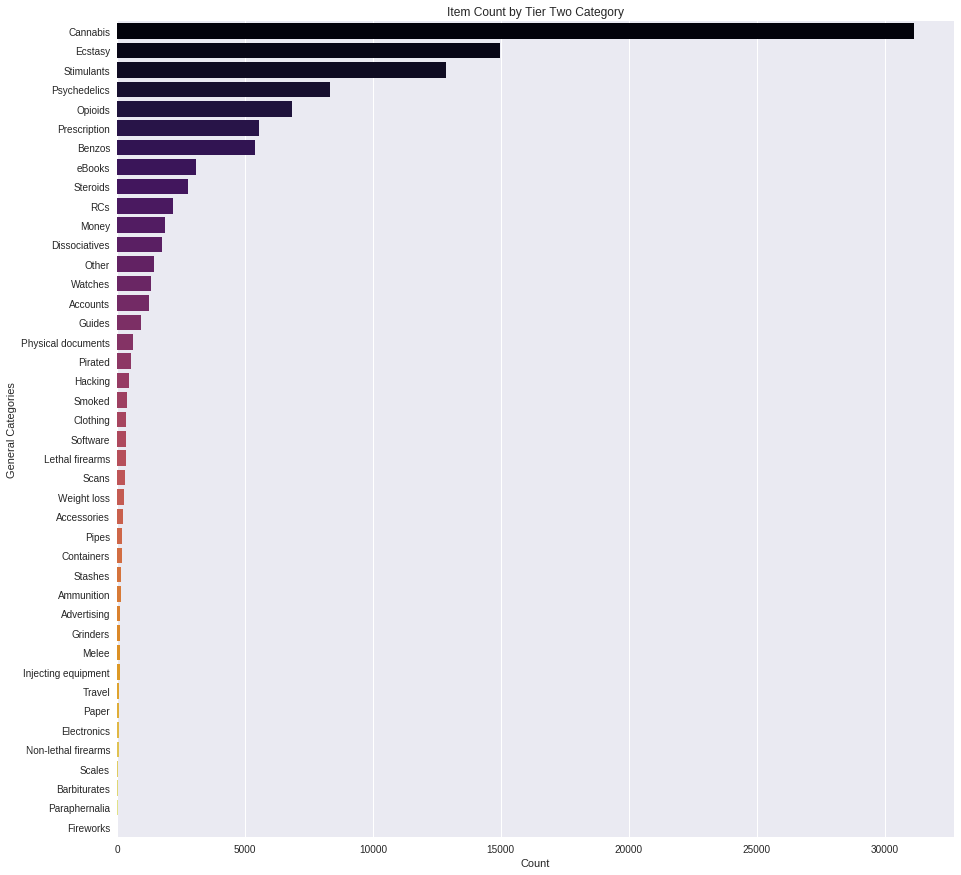

In [11]:
withsub2 = df.loc[df.cat2.notnull(),["cat1"]].reset_index()["cat1"].unique()
print("Unique Subcategory for Tier Two with SubClass:\n", withsub2)

print("\nTier Two Subcategories")
print(df.query("cat1 in @withsub2")["cat2"].unique())

countplot("cat2", "Tier Two Category", size=(15,15))

Unique Subcategory for Tier Three with SubClass
 ['Scans' 'Cannabis' 'Dissociatives' 'Ecstasy' 'Stimulants' 'Psychedelics'
 'eBooks' 'Opioids' 'Injecting equipment']

Tier Three Subcategories
[None 'Photos' 'Weed' 'Shake' 'Synthetics' 'Concentrates' 'Seeds' 'Hash'
 'MXE' 'Ketamine' 'Edibles' 'Pills' 'Other' 'Meth' 'LSD' 'Speed' 'GHB'
 'Cocaine' 'NB' 'Mushrooms' 'MDMA' 'DMT' 'Prescription' 'MDA' 'Others'
 'Mescaline' '2C' 'Anonymity' 'Relationships' 'Economy' 'Politics'
 'Morphine' 'Heroin' 'Science' 'Drugs' 'Fentanyl' 'Oxycodone' '5-MeO'
 'Buprenorphine' 'Doomsday' 'IT' 'Psychology' 'Making money' 'Spores'
 'Hydrocodone' 'Philosophy' 'Codeine' 'Aliens' 'Dihydrocodeine'
 'Mephedrone' 'GBL' 'Syringes' 'Opium' 'Salvia' 'Filters' 'Needles' 'PCP']


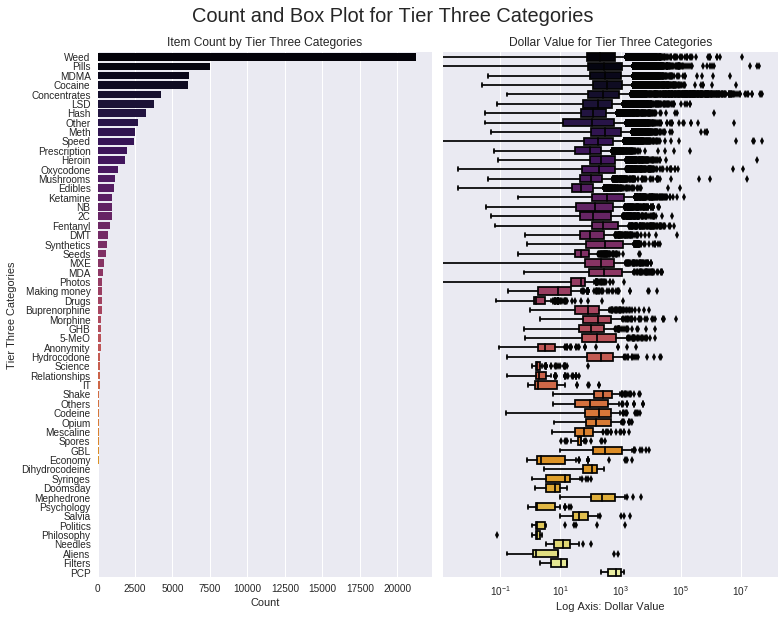

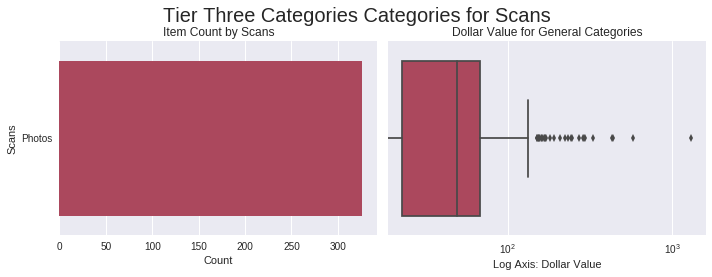

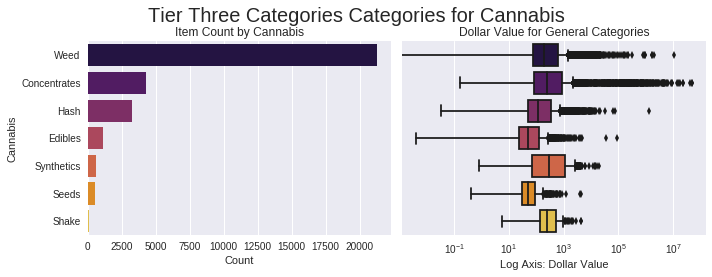

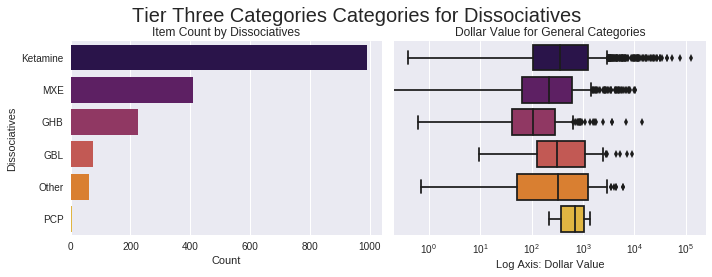

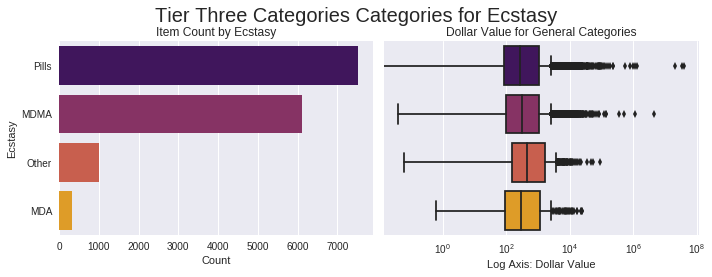

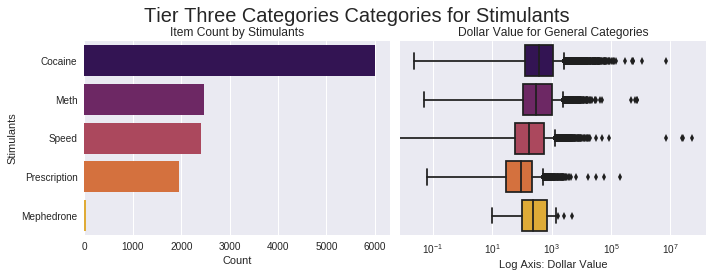

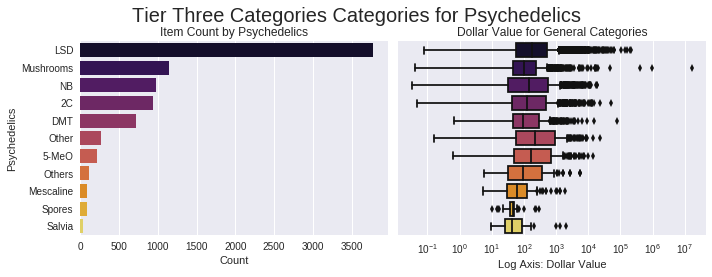

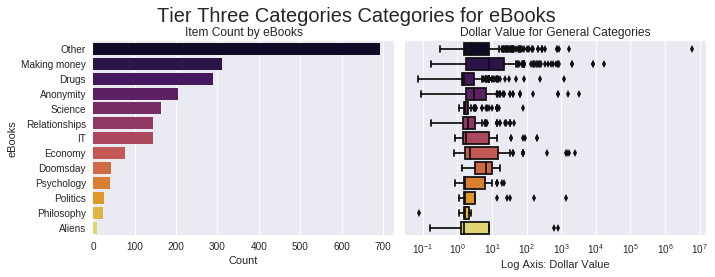

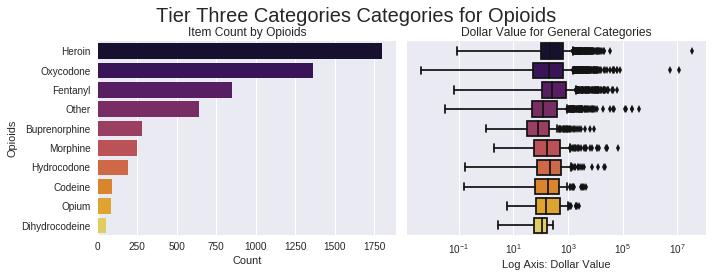

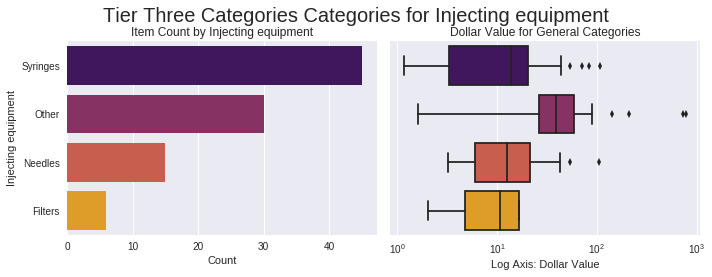

In [12]:
cats = ["cat1","cat2","cat3", "cat4"]
withsub3 = df.loc[df.cat3.notnull(),["cat2"]].reset_index()["cat2"].unique()
print("Unique Subcategory for Tier Three with SubClass\n",  withsub3)

print("\nTier Three Subcategories")
print(df.query("cat2 in @withsub3")["cat3"].unique())

catplot("cat3", level="Tier Three Categories", size=(11,9))

for x in withsub3:
    catinabox_plot(x, parentcat="cat2",kitten="cat3", level="Tier Three Categories", size=(10,4))

# Chi-Square Testing

In [13]:
new_df = df[['Category','Origin']]
list(new_df)

['Category', 'Origin']

In [14]:
df.head()

,Vendor,Category,Item,ItemDescription,Price,Origin,Destination,Rating,Remarks,BTC,Value,LogValue,Score,Deals,cat1,cat2,cat3,cat4
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,Torland,NaN,4.96/5,NaN,0.050270,20.058,2.999,4.96,NaN,Services,Hacking,None,None
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,Torland,NaN,4.96/5,NaN,0.152420,60.815,4.108,4.96,NaN,Services,Hacking,None,None
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,Torland,NaN,4.93/5,NaN,0.007000,2.793,1.027,4.93,NaN,Services,Hacking,None,None
3,cyberzen,Services/Hacking,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019016783532494728 BTC,NaN,NaN,4.89/5,NaN,0.019017,7.588,2.027,4.89,NaN,Services,Hacking,None,None
4,businessdude,Services/Hacking,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018073963963936 BTC,Torland,NaN,4.88/5,NaN,0.062018,24.745,3.209,4.88,NaN,Services,Hacking,None,None


In [0]:
physicalobjects = ['Drugs/RCs', 'Drugs/Weight loss', 'Drugs/Steroids',
       'Drugs/Prescription', 'Drugs/Other', 'Drugs/Cannabis/Weed',
       'Drugs/Benzos', 'Drugs/Cannabis/Shake/trim',
       'Drugs/Cannabis/Synthetics', 'Drugs/Cannabis/Concentrates',
       'Drugs/Cannabis/Seeds', 'Drugs/Cannabis/Hash',
       'Drugs/Dissociatives/MXE', 'Drugs/Dissociatives/Ketamine',
       'Drugs/Cannabis/Edibles', 'Drugs/Ecstasy/Pills',
       'Drugs/Ecstasy/Other', 'Drugs/Stimulants/Meth',
       'Drugs/Psychedelics/LSD', 'Drugs/Stimulants/Speed',
       'Drugs/Dissociatives/GHB', 'Drugs/Stimulants/Cocaine',
       'Drugs/Psychedelics/NB', 'Drugs/Psychedelics/Mushrooms',
       'Drugs/Ecstasy/MDMA', 'Drugs/Psychedelics/DMT',
       'Drugs/Stimulants/Prescription', 'Drugs/Ecstasy/MDA',
       'Drugs/Psychedelics/Others', 'Drugs/Psychedelics/Mescaline',
       'Drugs/Psychedelics/2C', 'Drugs/Opioids', 'Drugs/Opioids/Morphine',
       'Drugs/Opioids/Other', 'Drugs/Opioids/Heroin', 'Info/eBooks/Drugs',
       'Drugs/Opioids/Fentanyl', 'Drugs/Opioids/Oxycodone',
       'Drugs/Psychedelics/5-MeO', 'Drugs/Opioids/Buprenorphine',
       'Drugs/Psychedelics/Other', 'Drugs/Psychedelics/Spores',
       'Drugs/Opioids/Hydrocodone', 'Drugs/Dissociatives/Other',
       'Drugs/Opioids/Codeine', 'Drugs/Opioids/Dihydrocodeine',
       'Drugs/Stimulants/Mephedrone', 'Drugs/Dissociatives/GBL',
       'Drugs/Opioids/Opium', 'Drugs/Psychedelics/Salvia',
       'Drugs/Barbiturates', 'Drugs/Dissociatives/PCP', 'Drug paraphernalia/Pipes', 'Drug paraphernalia/Stashes',
       'Drug paraphernalia/Containers', 'Drug paraphernalia/Grinders',
       'Drug paraphernalia/Paper',
       'Drug paraphernalia/Injecting equipment/Syringes',
       'Drug paraphernalia/Injecting equipment/Other',
       'Drug paraphernalia/Scales',
       'Drug paraphernalia/Injecting equipment/Filters',
       'Drug paraphernalia/Injecting equipment/Needles', 'Counterfeits/Money', 'Counterfeits/Clothing',
       'Counterfeits/Accessories', 'Counterfeits/Watches',
       'Counterfeits/Electronics', 'Forgeries/Physical documents', 'Forgeries/Scans/Photos',
       'Forgeries/Other', 'Forgeries', 'Weapons/Lethal firearms', 'Weapons/Melee',
       'Weapons/Non-lethal firearms', 'Weapons/Ammunition',
       'Weapons/Fireworks', 'Electronics', 'Tobacco/Smoked', 'Tobacco/Paraphernalia', 'Jewelry', 'Chemicals']

countries = ['Usa', 'Uk', 'Australia', 'Germany', 'Netherlands', 'Canada', 'Eu', 'China', 'Torland', 'Belgium', 'India', 'Sweden', 'France']

In [0]:
# extracting all physical objects and single origin countries
new_df = (new_df.loc[df['Category'].isin(physicalobjects) & new_df['Origin'].isin(countries)])

In [17]:
new_df

,Category,Origin
125,Drugs/RCs,China
131,Drugs/RCs,China
132,Drugs/RCs,China
134,Drugs/RCs,China
135,Drugs/RCs,Usa
136,Drugs/RCs,Usa
142,Drugs/RCs,Netherlands
143,Drugs/RCs,Eu
145,Drugs/RCs,Usa
148,Drugs/RCs,China


In [18]:
# getting contingency table
cont_table = pd.crosstab(new_df['Category'], new_df['Origin'])
cont_table

Origin,Australia,Belgium,Canada,China,Eu,France,Germany,India,Netherlands,Sweden,Torland,Uk,Usa
Category,,,,,,,,,,,,,
Chemicals,3,0,0,5,41,0,1,6,0,0,0,1,20
Counterfeits/Accessories,1,0,0,86,2,0,0,4,18,0,7,1,55
Counterfeits/Clothing,0,0,0,268,0,0,0,0,0,0,5,0,1
Counterfeits/Electronics,1,0,2,19,5,0,0,0,7,0,7,1,0
Counterfeits/Money,2,1,0,0,72,0,1,0,11,0,29,22,155
Counterfeits/Watches,2,0,0,823,0,0,0,3,0,0,54,0,12
Drug paraphernalia/Containers,8,0,0,0,0,0,0,0,2,4,1,40,129
Drug paraphernalia/Grinders,5,0,1,0,0,0,0,0,1,0,0,50,46
Drug paraphernalia/Injecting equipment/Filters,3,0,0,0,0,0,0,0,0,0,0,0,3


In [19]:
import scipy.stats as stats
stats.chi2_contingency(cont_table)
# returns: chi2, p value, dof, expected frequencies

(112565.46169485553,
 0.0,
 960,
 array([[  7.67787929,   0.383486  ,   4.62359008, ...,   0.76334566,
           9.29341606,  30.02069842],
        [ 17.35001295,   0.86657876,  10.44811265, ...,   1.72496291,
          21.00070643,  67.83898086],
        [ 27.32128476,   1.36461252,  16.4527751 , ...,   2.71632091,
          33.07007794, 106.82690089],
        ...,
        [ 17.54943839,   0.87653943,  10.5682059 , ...,   1.74479007,
          21.24209386,  68.61873926],
        [  8.97414463,   0.44823039,   5.4041962 , ...,   0.8922222 ,
          10.86243436,  35.08912803],
        [  3.39023242,   0.16933148,   2.04158523, ...,   0.33706172,
           4.10358631,  13.25589281]]))

In [20]:
import scipy.stats as stats
stats.chi2_contingency(cont_table, correction = False)

(112565.46169485553,
 0.0,
 960,
 array([[  7.67787929,   0.383486  ,   4.62359008, ...,   0.76334566,
           9.29341606,  30.02069842],
        [ 17.35001295,   0.86657876,  10.44811265, ...,   1.72496291,
          21.00070643,  67.83898086],
        [ 27.32128476,   1.36461252,  16.4527751 , ...,   2.71632091,
          33.07007794, 106.82690089],
        ...,
        [ 17.54943839,   0.87653943,  10.5682059 , ...,   1.74479007,
          21.24209386,  68.61873926],
        [  8.97414463,   0.44823039,   5.4041962 , ...,   0.8922222 ,
          10.86243436,  35.08912803],
        [  3.39023242,   0.16933148,   2.04158523, ...,   0.33706172,
           4.10358631,  13.25589281]]))

In [21]:
new_df.describe()

,Category,Origin
count,84934,84934
unique,81,13
top,Drugs/Cannabis/Weed,Usa
freq,19239,33114


Text(0.5,1,'Category Frequencies')

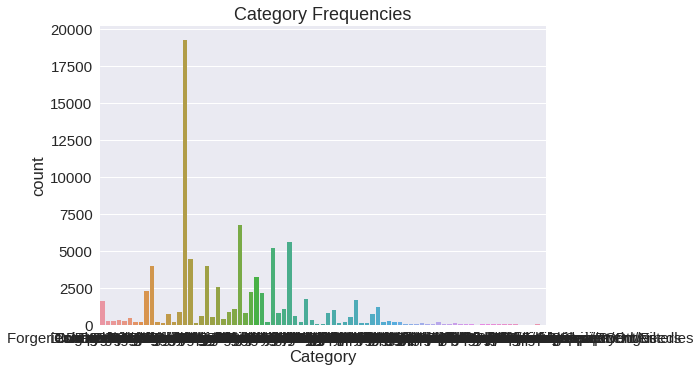

In [22]:
# import seaborn and alias it as sns
import seaborn as sns

###*                               ## fonts
# Bigger than normal fonts
sns.set(font_scale=1.5)

###*                               ## plottin
# make a barplot of your, chosen categorical, column from the dataframe
sns.countplot(new_df['Category']).set_title("Category Frequencies")

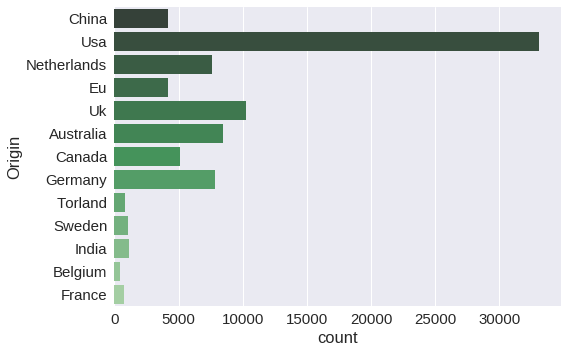

In [0]:
import seaborn as sns
sns.countplot(y='Origin', data=new_df, palette="Greens_d")

In [24]:
cont_table

Origin,Australia,Belgium,Canada,China,Eu,France,Germany,India,Netherlands,Sweden,Torland,Uk,Usa
Category,,,,,,,,,,,,,
Chemicals,3,0,0,5,41,0,1,6,0,0,0,1,20
Counterfeits/Accessories,1,0,0,86,2,0,0,4,18,0,7,1,55
Counterfeits/Clothing,0,0,0,268,0,0,0,0,0,0,5,0,1
Counterfeits/Electronics,1,0,2,19,5,0,0,0,7,0,7,1,0
Counterfeits/Money,2,1,0,0,72,0,1,0,11,0,29,22,155
Counterfeits/Watches,2,0,0,823,0,0,0,3,0,0,54,0,12
Drug paraphernalia/Containers,8,0,0,0,0,0,0,0,2,4,1,40,129
Drug paraphernalia/Grinders,5,0,1,0,0,0,0,0,1,0,0,50,46
Drug paraphernalia/Injecting equipment/Filters,3,0,0,0,0,0,0,0,0,0,0,0,3


In [25]:
cont_table.describe()

Origin,Australia,Belgium,Canada,China,Eu,France,Germany,India,Netherlands,Sweden,Torland,Uk,Usa
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,104.555556,5.222222,62.962963,51.506173,51.938272,9.493827,96.716049,13.691358,94.000000,12.716049,10.395062,126.555556,408.814815
std,220.109007,19.481401,240.566854,134.676661,95.459592,27.186910,293.931337,68.964600,335.769676,36.432552,22.613425,301.875388,1207.508055
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,16.000000
50%,16.000000,0.000000,3.000000,1.000000,18.000000,0.000000,4.000000,0.000000,2.000000,0.000000,1.000000,17.000000,77.000000
75%,61.000000,0.000000,48.000000,27.000000,58.000000,1.000000,33.000000,2.000000,28.000000,4.000000,7.000000,97.000000,300.000000
max,1241.000000,124.000000,2094.000000,823.000000,603.000000,110.000000,1676.000000,548.000000,2582.000000,236.000000,136.000000,2172.000000,10045.000000


# Seconday Testing


In [26]:
second = df[['cat1','Origin']]
list(second)
second.head()

,cat1,Origin
0,Services,Torland
1,Services,Torland
2,Services,Torland
3,Services,NaN
4,Services,Torland


In [0]:
countries = ['Usa', 'Uk', 'Australia', 'Germany', 'Netherlands', 'Canada', 'Eu', 'China', 'Torland', 'Belgium', 'India', 'Sweden', 'France']

In [0]:
#second = second[second.Origin == countries]
second = second.loc[second['Origin'].isin(countries)]


In [30]:
second.head()

,cat1,Origin
0,Services,Torland
1,Services,Torland
2,Services,Torland
4,Services,Torland
5,Services,Torland


In [31]:
second.describe()

,cat1,Origin
count,89025,89025
unique,14,13
top,Drugs,Usa
freq,80438,33824


In [0]:
cont_table = pd.crosstab(second['cat1'], second['Origin'])
flip = cont_table.transpose()

In [33]:
cont_table.head()

Origin,Australia,Belgium,Canada,China,Eu,France,Germany,India,Netherlands,Sweden,Torland,Uk,Usa
cat1,,,,,,,,,,,,,
Chemicals,3,0,0,5,41,0,1,6,0,0,0,1,20
Counterfeits,6,1,2,1196,79,0,1,7,36,0,102,24,223
Data,22,127,4,0,5,0,7,1,0,1,591,8,171
Drug paraphernalia,103,0,6,0,3,0,0,1,3,5,1,163,534
Drugs,8152,420,5081,2811,3803,764,7749,1094,7565,984,282,9975,31758


In [34]:
flip.head()

cat1,Chemicals,Counterfeits,Data,Drug paraphernalia,Drugs,Electronics,Forgeries,Info,Information,Jewelry,Other,Services,Tobacco,Weapons
Origin,,,,,,,,,,,,,,
Australia,3,6,22,103,8152,93,36,5,13,11,95,163,16,49
Belgium,0,1,127,0,420,0,0,0,257,2,120,231,0,0
Canada,0,2,4,6,5081,5,0,1,1,2,9,12,0,3
China,5,1196,0,0,2811,26,0,0,0,88,11,2,5,41
Eu,41,79,5,3,3803,25,66,4,11,1,36,93,106,83


In [35]:
from scipy.stats import chi2_contingency
chi2_contingency(cont_table)

(77546.3735069005,
 0.0,
 156,
 array([[7.58280258e+00, 1.00158382e+00, 4.43360854e+00, 3.61971356e+00,
         3.76761584e+00, 6.69452401e-01, 6.81301881e+00, 9.60932322e-01,
         6.66598147e+00, 8.95197978e-01, 2.34048863e+00, 8.99436113e+00,
         2.92552429e+01],
        [1.65147532e+02, 2.18137152e+01, 9.65605392e+01, 7.88345409e+01,
         8.20557372e+01, 1.45801516e+01, 1.48382241e+02, 2.09283572e+01,
         1.45179882e+02, 1.94967144e+01, 5.09740185e+01, 1.95890177e+02,
         6.37156394e+02],
        [9.22738444e+01, 1.21881045e+01, 5.39518338e+01, 4.40476832e+01,
         4.58474810e+01, 8.14645324e+00, 8.29064757e+01, 1.16934232e+01,
         8.11172030e+01, 1.08935131e+01, 2.84810110e+01, 1.09450862e+02,
         3.56002112e+02],
        [8.06534457e+01, 1.06532098e+01, 4.71574726e+01, 3.85005897e+01,
         4.00737321e+01, 7.12053917e+00, 7.24657456e+01, 1.02208256e+01,
         7.09018029e+01, 9.52165122e+00, 2.48942881e+01, 9.56672957e+01,
         3.1116

In [0]:
data = flip

In [37]:
chi2_contingency(flip)

(77546.37350690048,
 0.0,
 156,
 array([[7.58280258e+00, 1.65147532e+02, 9.22738444e+01, 8.06534457e+01,
         7.92136980e+03, 4.46105139e+01, 5.42613536e+01, 5.63293906e+01,
         5.92837293e+01, 1.19158326e+01, 7.78960629e+01, 1.26445695e+02,
         2.88540410e+01, 4.03759618e+01],
        [1.00158382e+00, 2.18137152e+01, 1.21881045e+01, 1.06532098e+01,
         1.04630389e+03, 5.89243471e+00, 7.16717776e+00, 7.44033698e+00,
         7.83056445e+00, 1.57391744e+00, 1.02889975e+01, 1.67017355e+01,
         3.81122157e+00, 5.33310868e+00],
        [4.43360854e+00, 9.65605392e+01, 5.39518338e+01, 4.71574726e+01,
         4.63156628e+03, 2.60834372e+01, 3.17262117e+01, 3.29353777e+01,
         3.46627577e+01, 6.96709913e+00, 4.55452513e+01, 7.39318618e+01,
         1.68707442e+01, 2.36075260e+01],
        [3.61971356e+00, 7.88345409e+01, 4.40476832e+01, 3.85005897e+01,
         3.78133142e+03, 2.12951980e+01, 2.59021061e+01, 2.68893008e+01,
         2.82995788e+01, 5.68812131e+00

In [38]:
flip.head()

cat1,Chemicals,Counterfeits,Data,Drug paraphernalia,Drugs,Electronics,Forgeries,Info,Information,Jewelry,Other,Services,Tobacco,Weapons
Origin,,,,,,,,,,,,,,
Australia,3,6,22,103,8152,93,36,5,13,11,95,163,16,49
Belgium,0,1,127,0,420,0,0,0,257,2,120,231,0,0
Canada,0,2,4,6,5081,5,0,1,1,2,9,12,0,3
China,5,1196,0,0,2811,26,0,0,0,88,11,2,5,41
Eu,41,79,5,3,3803,25,66,4,11,1,36,93,106,83


In [39]:
from sklearn import preprocessing

x = flip.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

#df.head()
chi2_contingency(df)

(46.108279317063534,
 1.0,
 156,
 array([[0.16600861, 0.12394404, 0.14014444, 0.13557087, 0.21559916,
         0.23834864, 0.22038553, 0.09433112, 0.1907287 , 0.12154202,
         0.23000229, 0.22430464, 0.2443349 , 0.28993296],
        [0.12715966, 0.09493894, 0.10734816, 0.10384489, 0.16514515,
         0.18257084, 0.16881142, 0.07225597, 0.14609481, 0.09309904,
         0.17617769, 0.17181339, 0.18715622, 0.22208353],
        [0.0191859 , 0.01432443, 0.01619674, 0.01566816, 0.02491717,
         0.02754637, 0.02547034, 0.01090201, 0.02204285, 0.01404682,
         0.02658177, 0.02592328, 0.02823821, 0.03350806],
        [0.17447853, 0.13026778, 0.14729474, 0.14248783, 0.22659924,
         0.25050941, 0.23162981, 0.09914399, 0.20045986, 0.12774321,
         0.24173723, 0.23574888, 0.2568011 , 0.30472562],
        [0.23073015, 0.17226592, 0.19478235, 0.1884257 , 0.2996545 ,
         0.33127328, 0.30630692, 0.13110786, 0.26508782, 0.16892743,
         0.31967295, 0.31175397, 0.3395934 , 

In [40]:
chi2_contingency(cont_table, lambda_= "cressie-read"     ) #original -
#chi2_contingency(flip) #transpose of original
#chi2_contingency(df) #normalized

(48853.6738729264,
 0.0,
 156,
 array([[7.58280258e+00, 1.00158382e+00, 4.43360854e+00, 3.61971356e+00,
         3.76761584e+00, 6.69452401e-01, 6.81301881e+00, 9.60932322e-01,
         6.66598147e+00, 8.95197978e-01, 2.34048863e+00, 8.99436113e+00,
         2.92552429e+01],
        [1.65147532e+02, 2.18137152e+01, 9.65605392e+01, 7.88345409e+01,
         8.20557372e+01, 1.45801516e+01, 1.48382241e+02, 2.09283572e+01,
         1.45179882e+02, 1.94967144e+01, 5.09740185e+01, 1.95890177e+02,
         6.37156394e+02],
        [9.22738444e+01, 1.21881045e+01, 5.39518338e+01, 4.40476832e+01,
         4.58474810e+01, 8.14645324e+00, 8.29064757e+01, 1.16934232e+01,
         8.11172030e+01, 1.08935131e+01, 2.84810110e+01, 1.09450862e+02,
         3.56002112e+02],
        [8.06534457e+01, 1.06532098e+01, 4.71574726e+01, 3.85005897e+01,
         4.00737321e+01, 7.12053917e+00, 7.24657456e+01, 1.02208256e+01,
         7.09018029e+01, 9.52165122e+00, 2.48942881e+01, 9.56672957e+01,
         3.1116

In [41]:
!pip install FisherExact

  Running setup.py bdist_wheel for FisherExact ... - \ | / - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/4d/59/8e/d6d3b7f28a1f832f12687e9d526bf1b1d0506918508376a85e
Successfully built FisherExact


In [42]:
from FisherExact import fisher_exact
fisher_exact(cont_table, alternative='greater', hybrid=True, midP=False, simulate_pval=True, replicate=20, workspace=300000000, attempt=20, seed=None)


0.047619047619047616

In [43]:
fisher_exact(cont_table, alternative='less', hybrid=True, midP=False, simulate_pval=True, replicate=20, workspace=300000000, attempt=20, seed=None)


0.047619047619047616

In [44]:
fisher_exact(flip, hybrid=True, midP=False, simulate_pval=True, replicate=20, workspace=300000000, attempt=20, seed=None)


0.047619047619047616